In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
%matplotlib inline
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

In [2]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train.drop(['Id'], axis=1, inplace=True)
data_test.drop(['Id'], axis=1, inplace=True)

In [3]:
print('train shape', data_train.shape)
print('test shape', data_test.shape)

train shape (1460, 80)
test shape (1459, 79)


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
data_train.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [6]:
data_train.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64

In [7]:
data_train.duplicated().sum()

np.int64(0)

In [8]:
data_train.nunique()

MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
Street              2
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 80, dtype: int64

In [9]:
duplicated = data_train.duplicated().sum()
duplicated

np.int64(0)

In [10]:
print(data_train.isnull().sum().sort_values(ascending=False).head())

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
dtype: int64


In [11]:
#take list at numeric/categorial features
numeric_features = data_train.drop(['SalePrice'], axis=1).select_dtypes(include= ['int64', 'float64'])
categorial_features = data_train.select_dtypes(include='object')
list_nf = numeric_features.columns.tolist()
list_cf = categorial_features.columns.tolist()

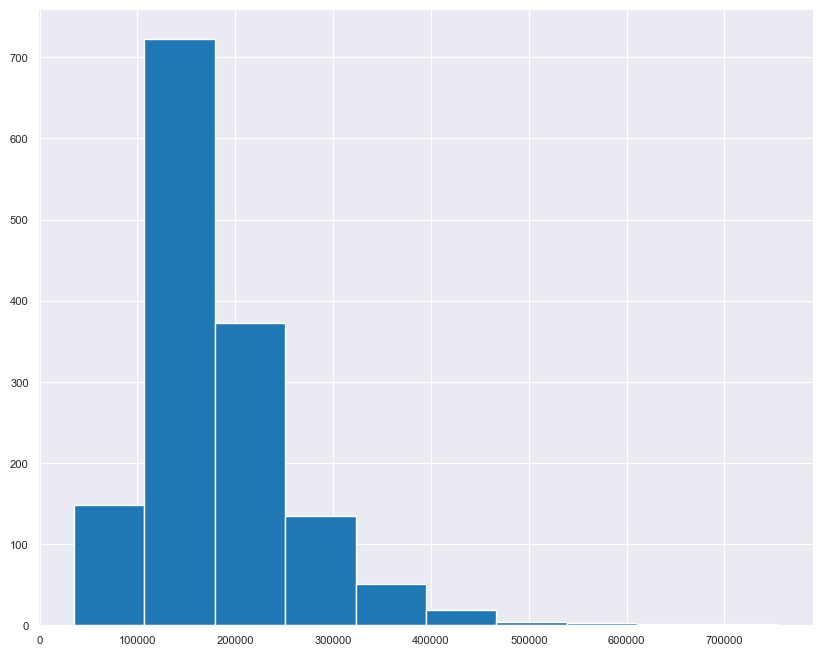

In [158]:
#distribution of SalePrice
data_train['SalePrice'].hist(figsize=(10, 8), bins=10, xlabelsize = 8, ylabelsize = 8);

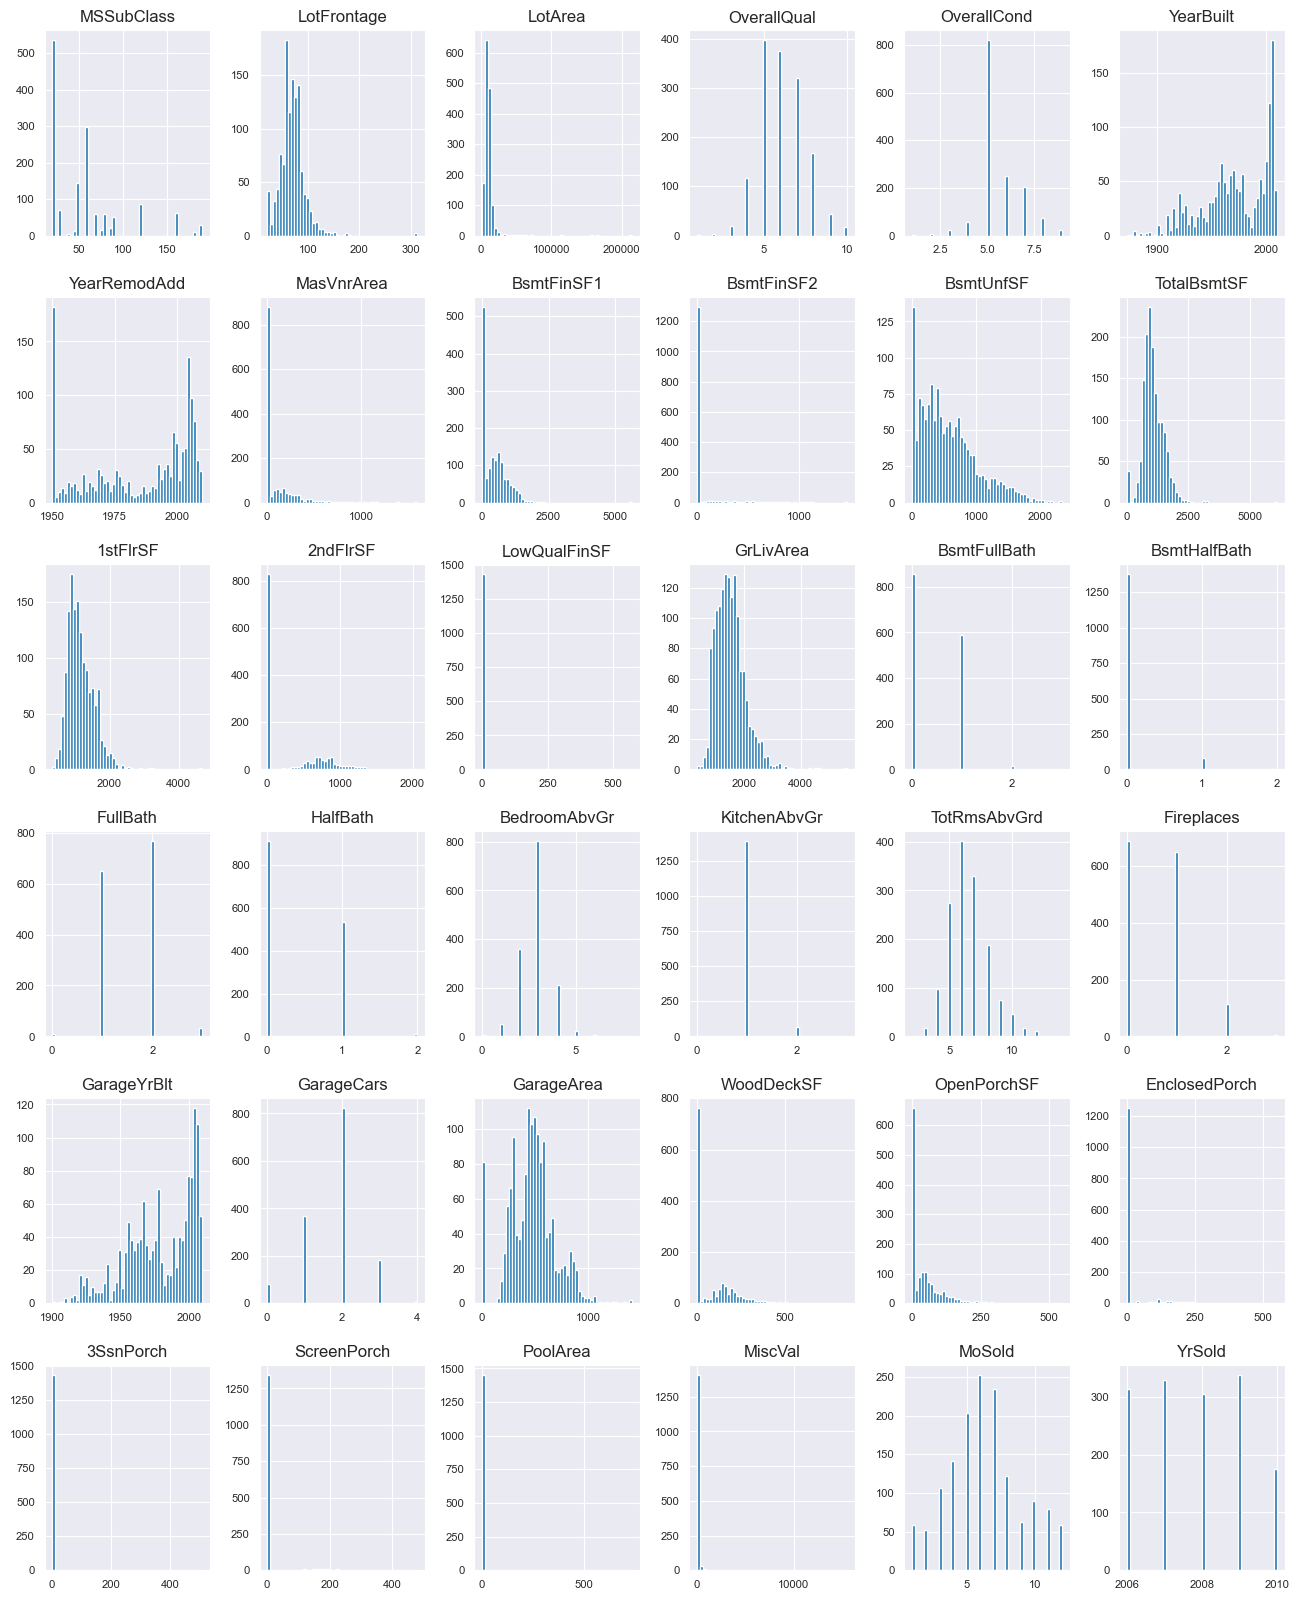

In [154]:
numeric_features.hist(figsize=(16, 20), bins=50, xlabelsize = 8, ylabelsize = 8);

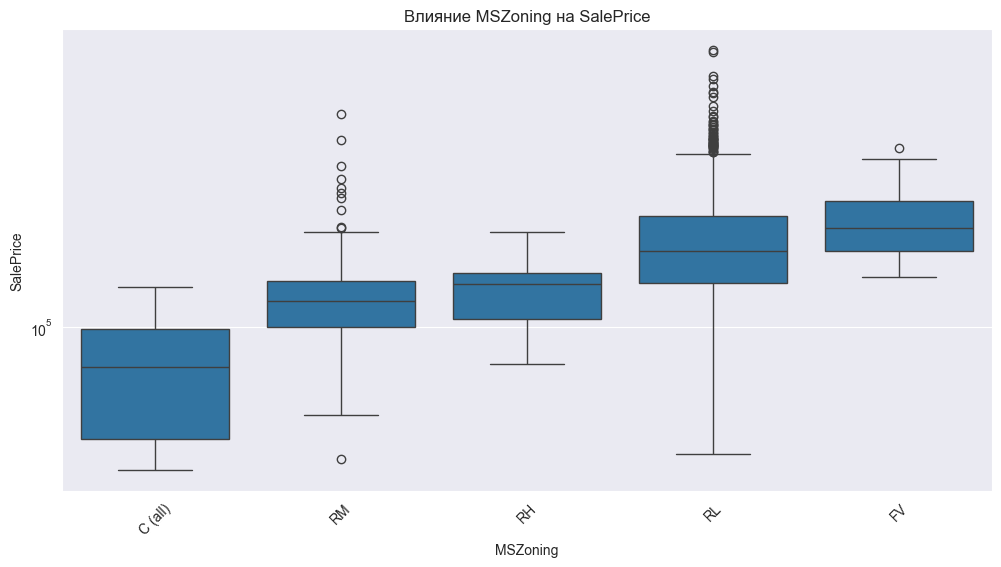

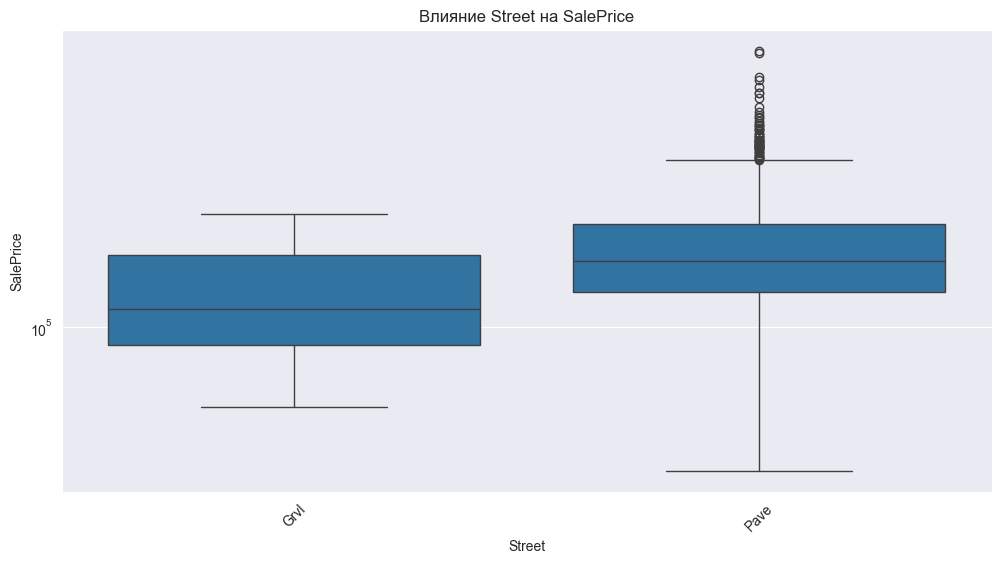

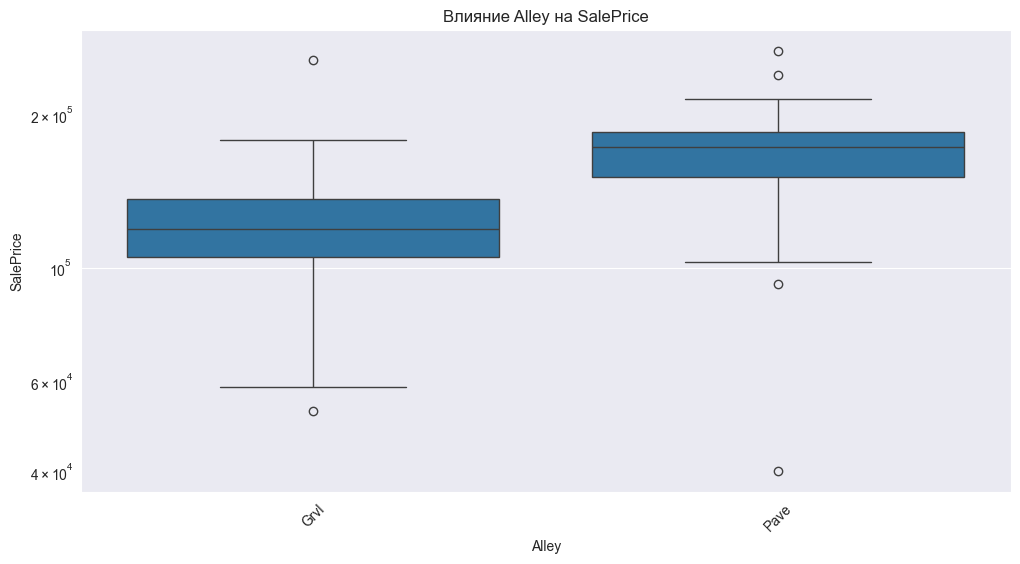

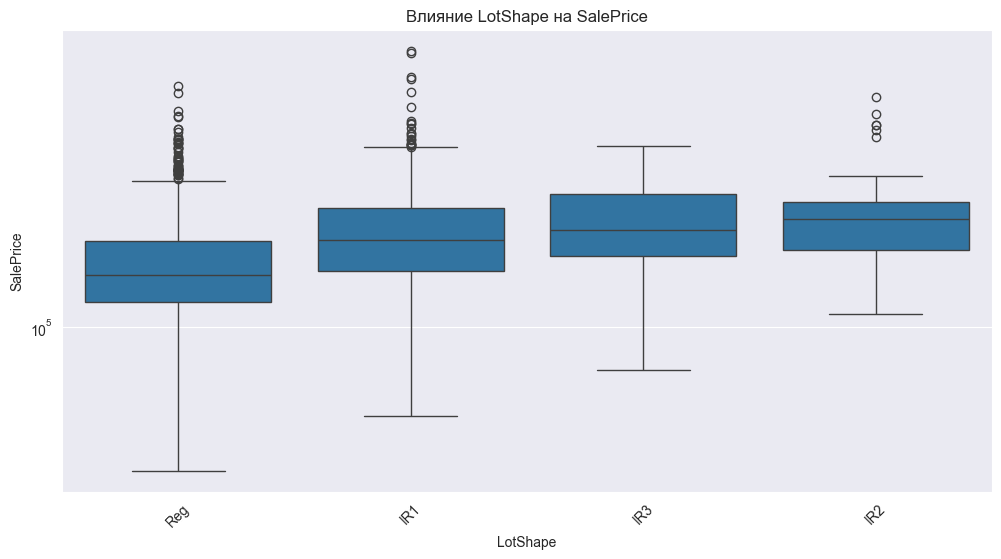

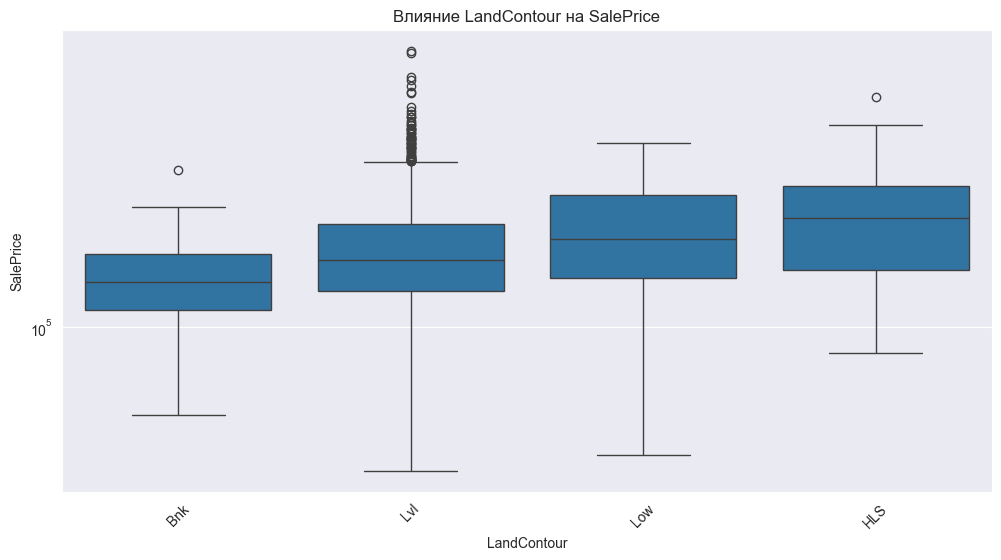

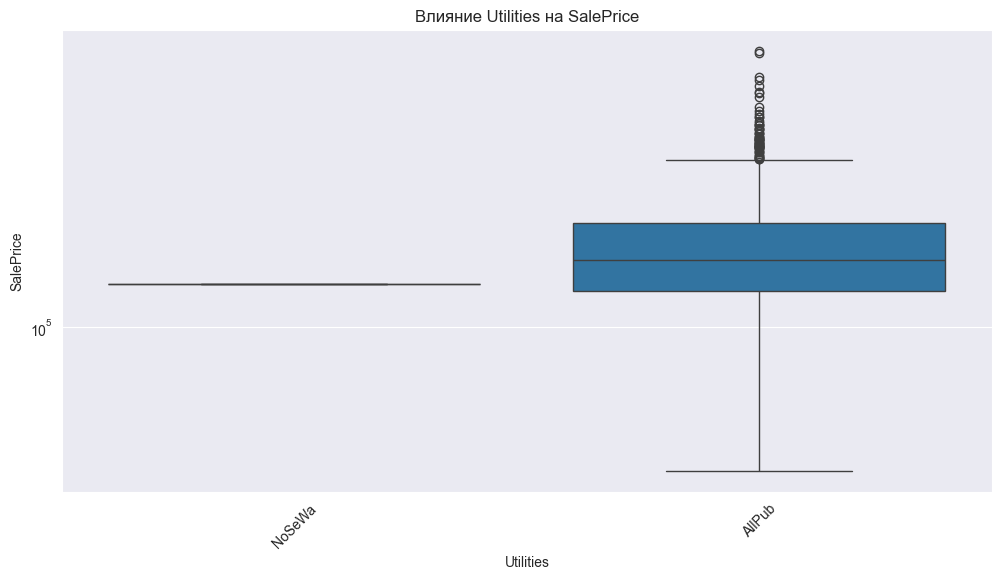

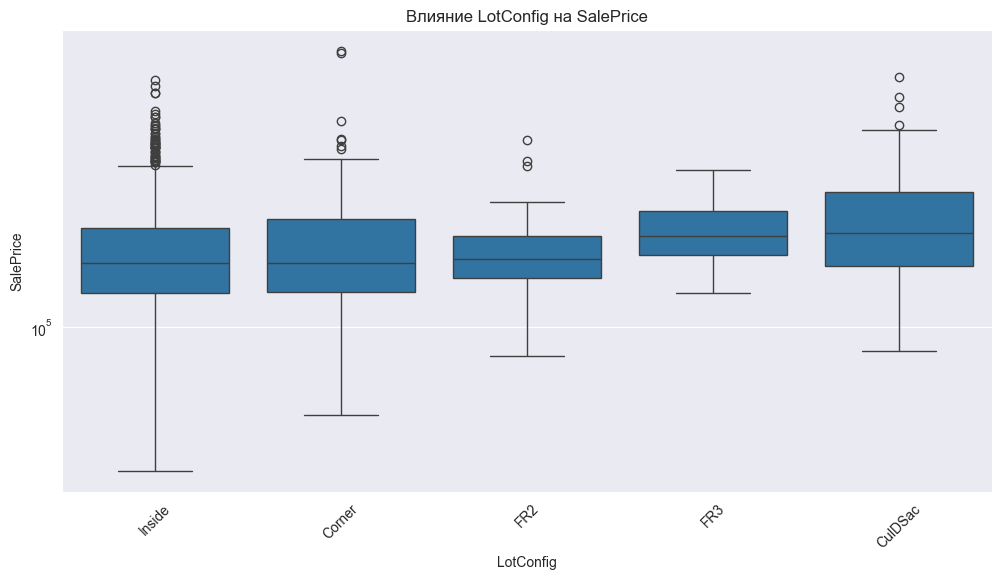

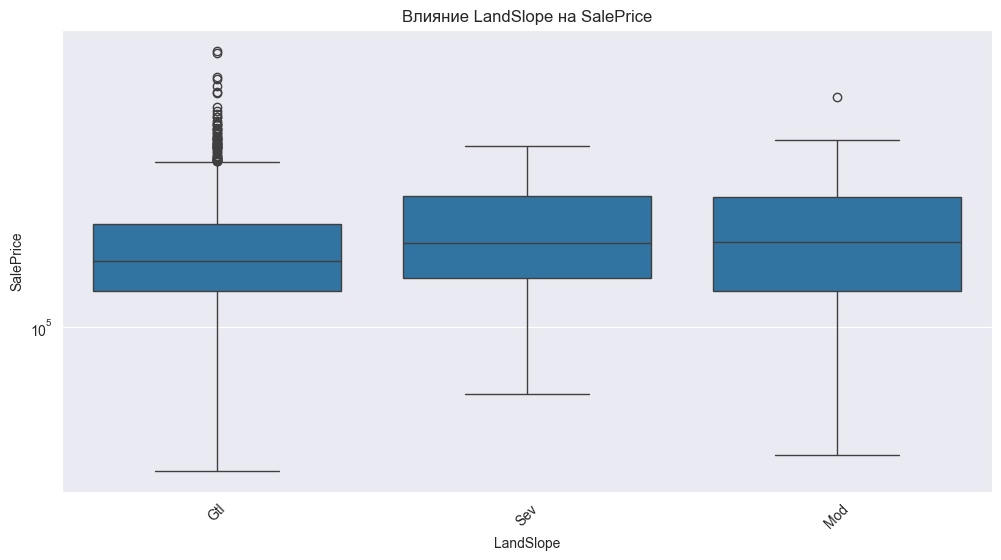

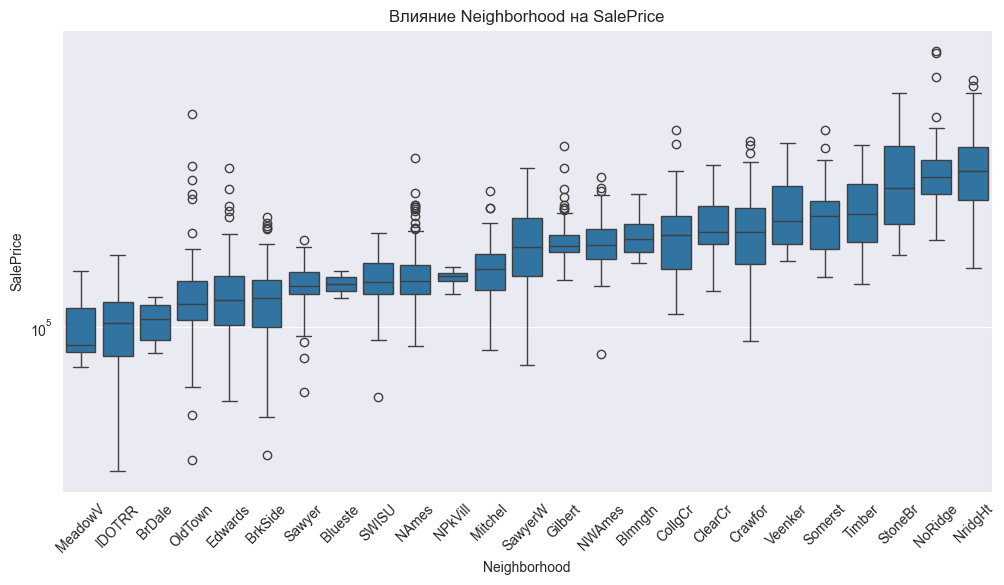

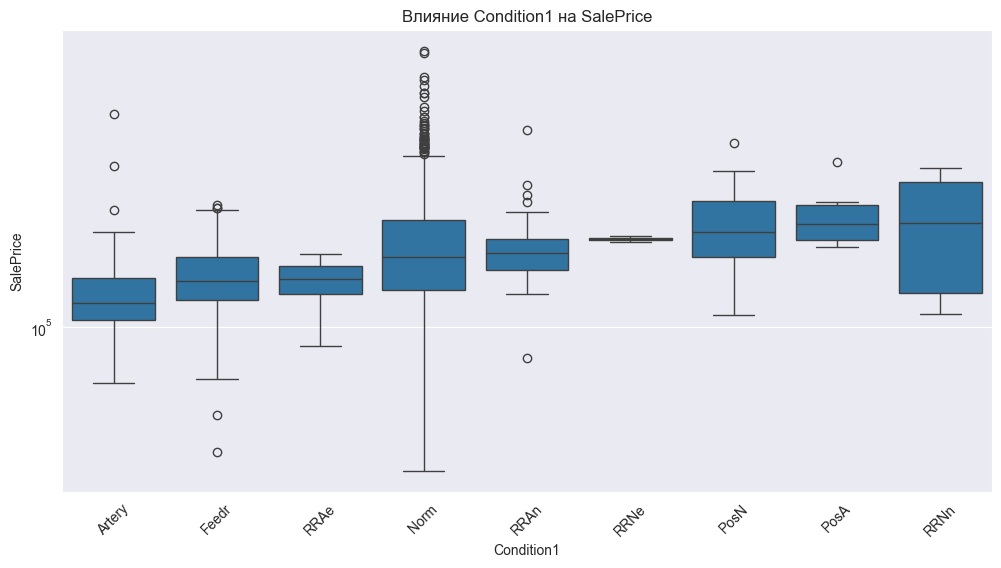

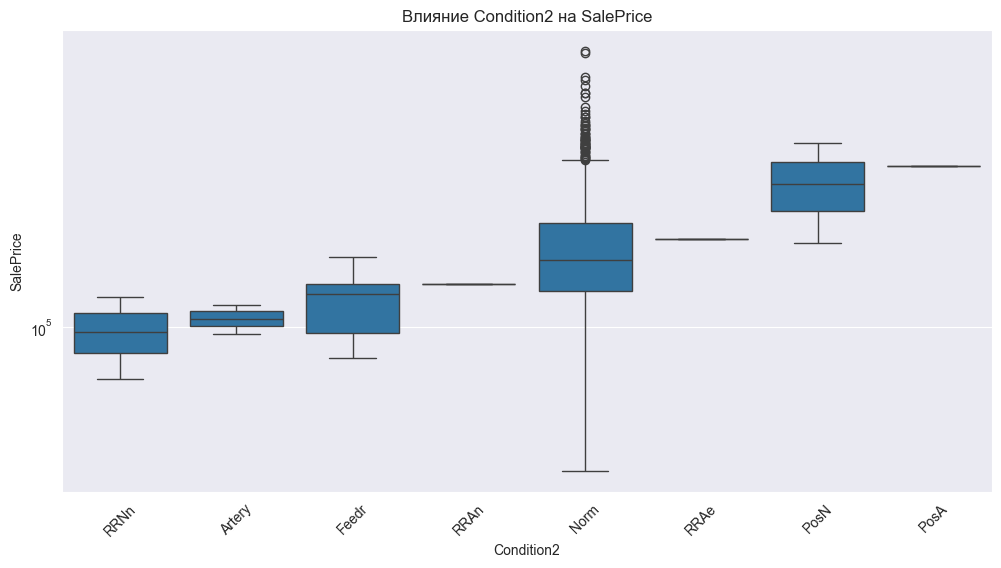

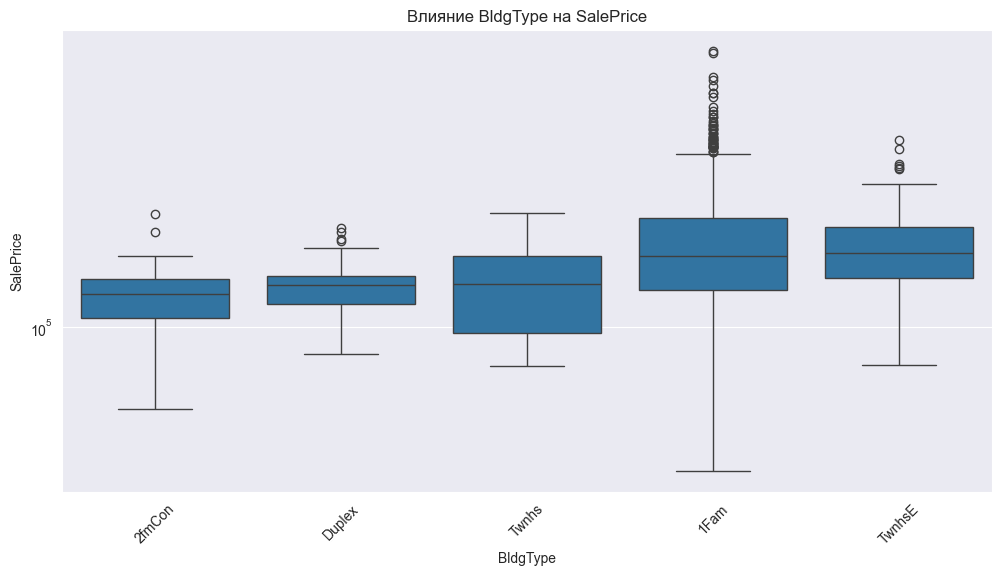

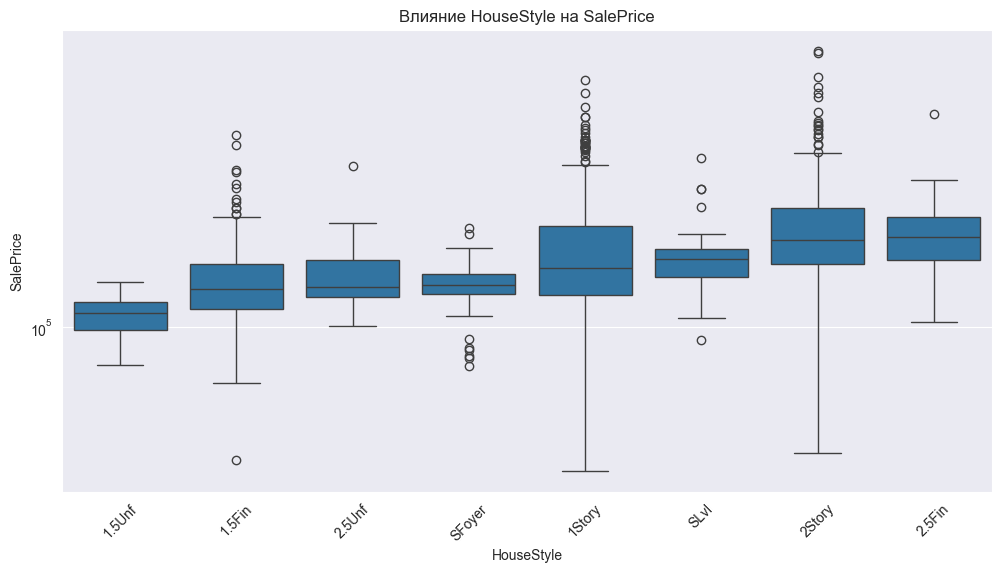

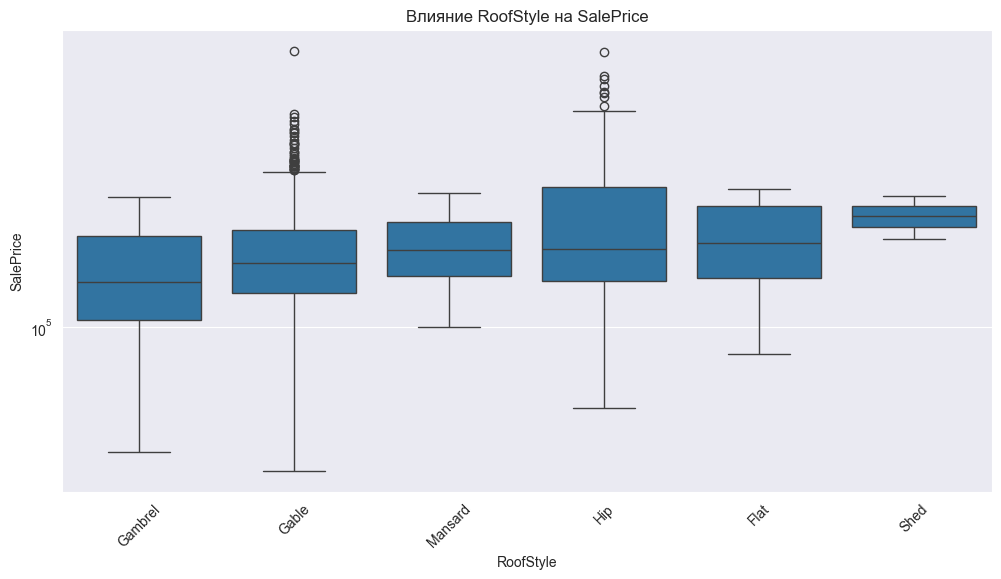

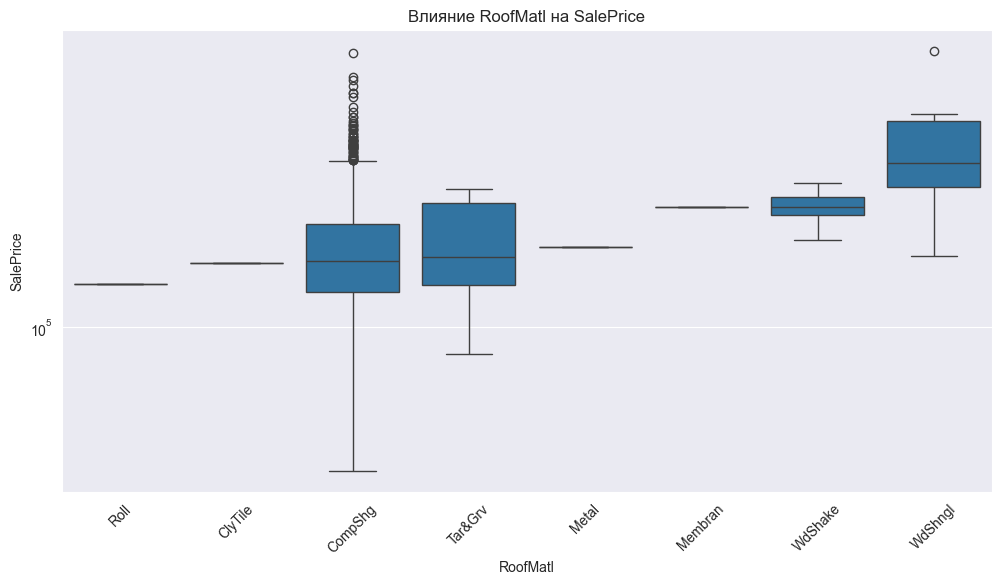

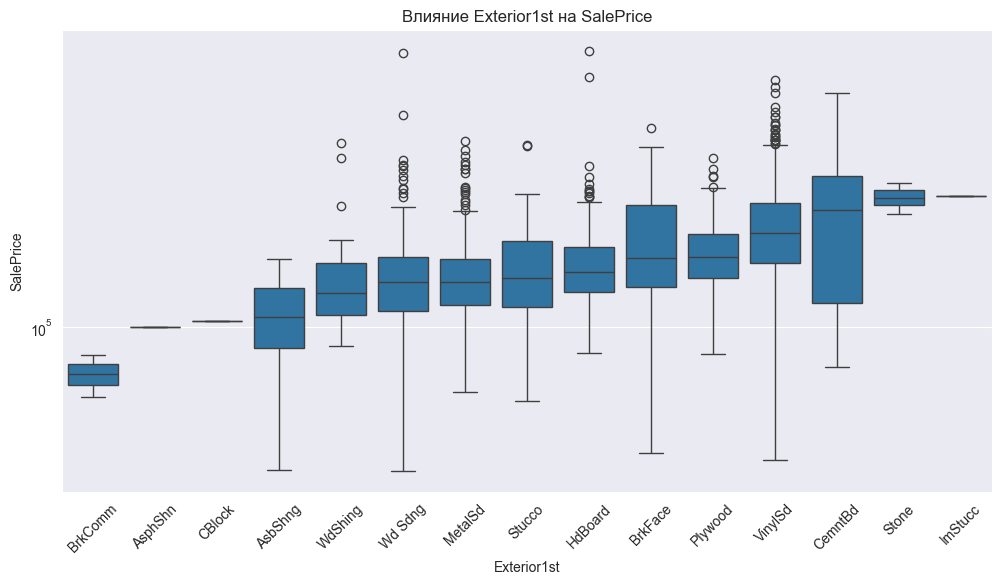

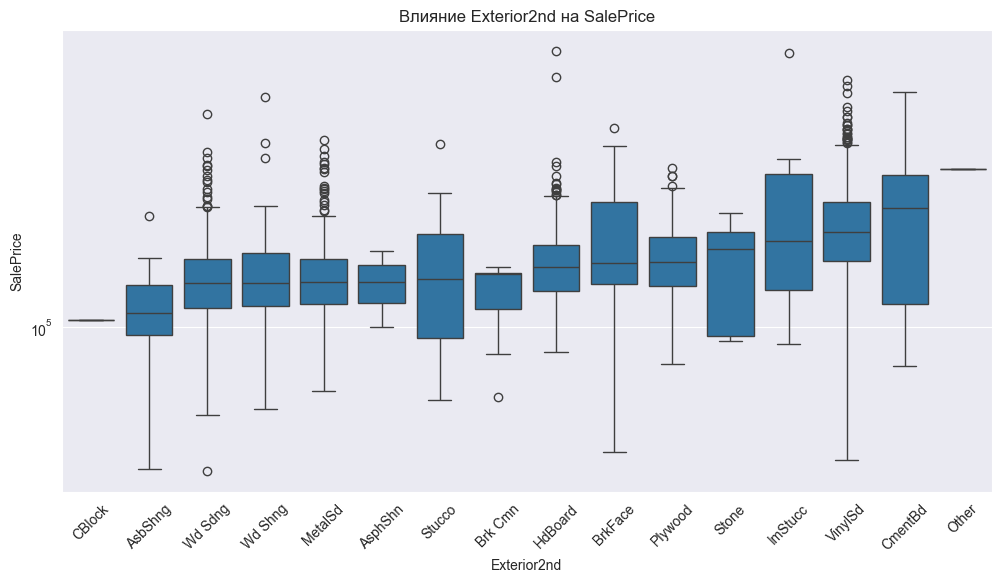

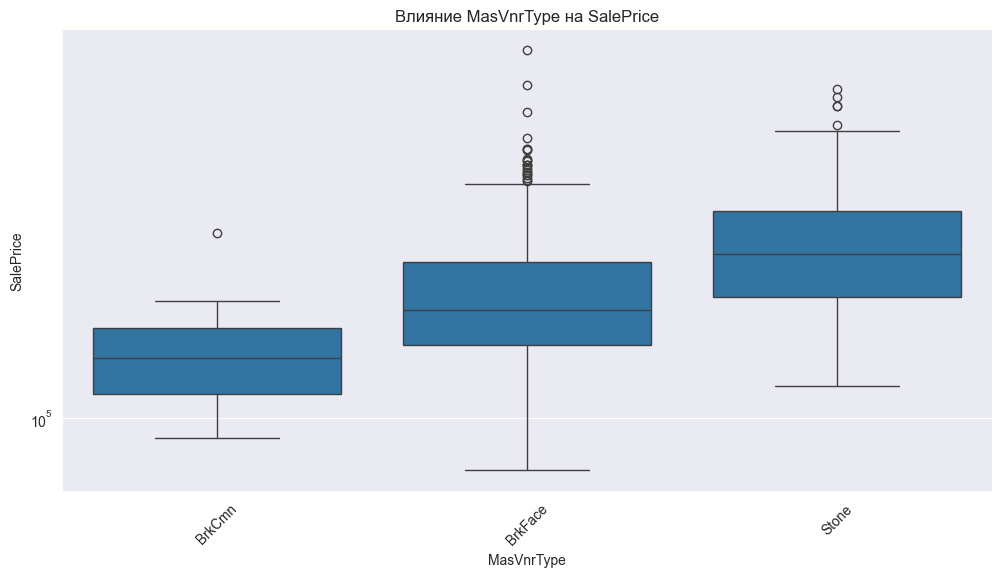

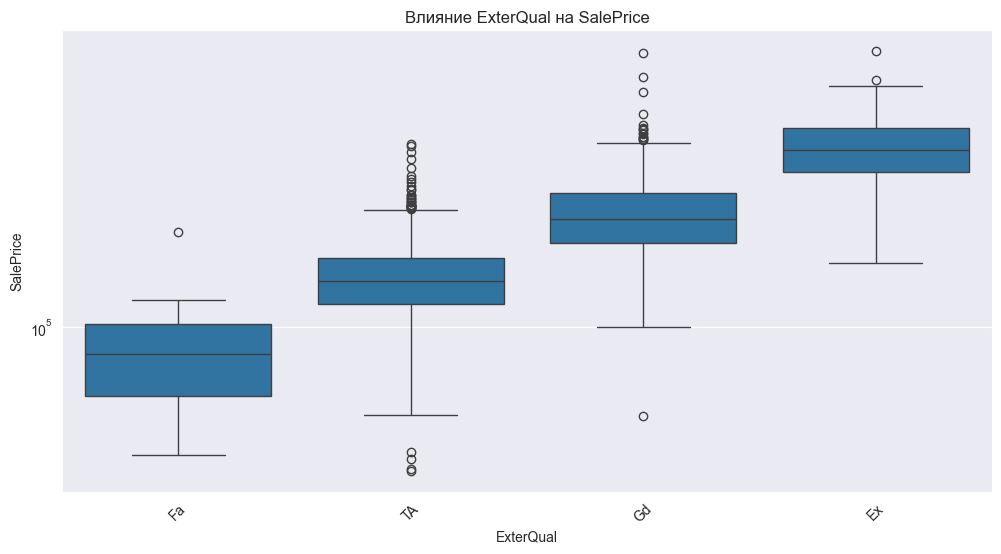

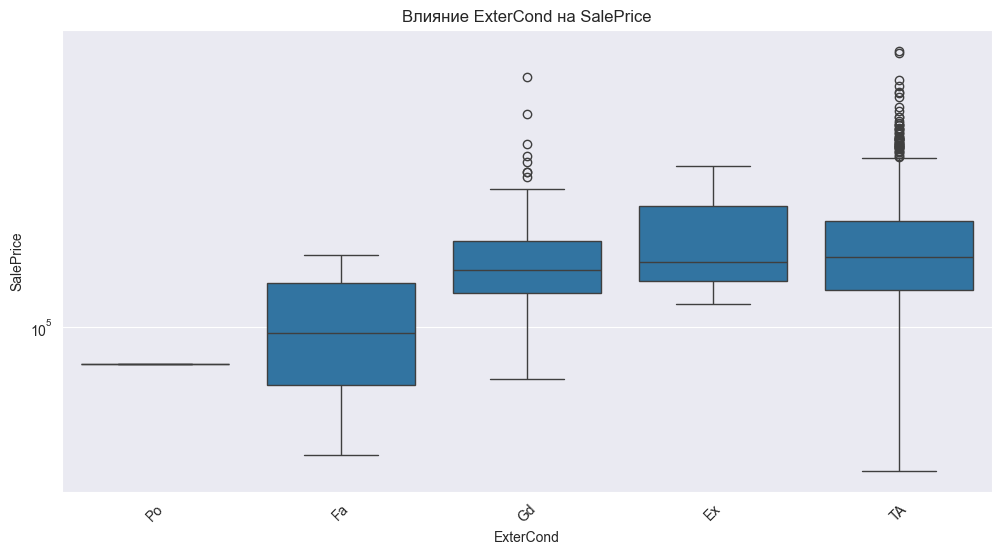

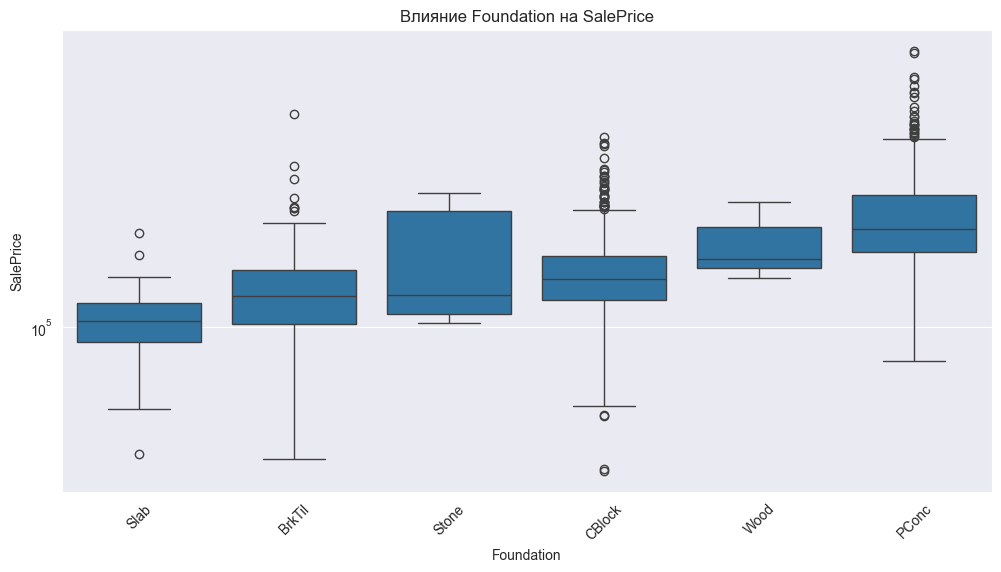

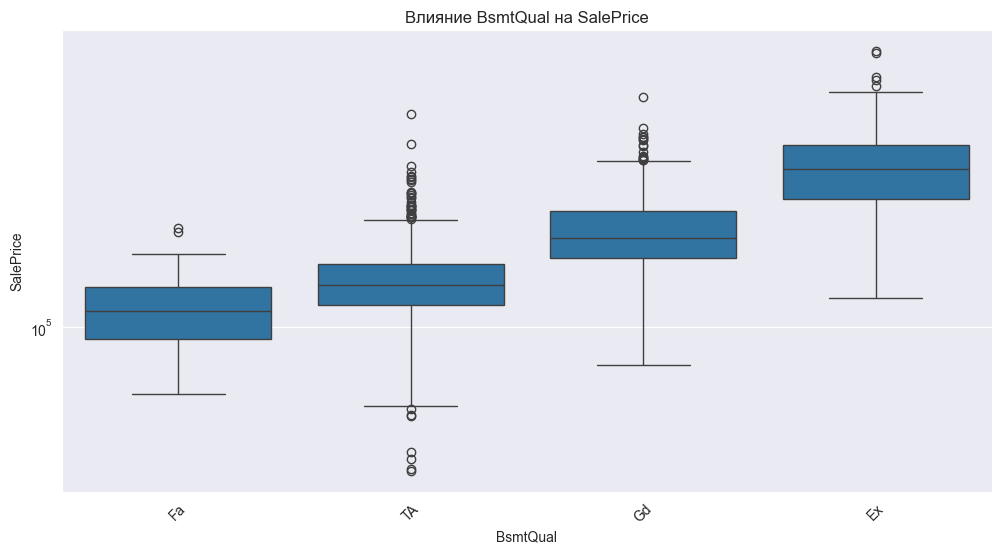

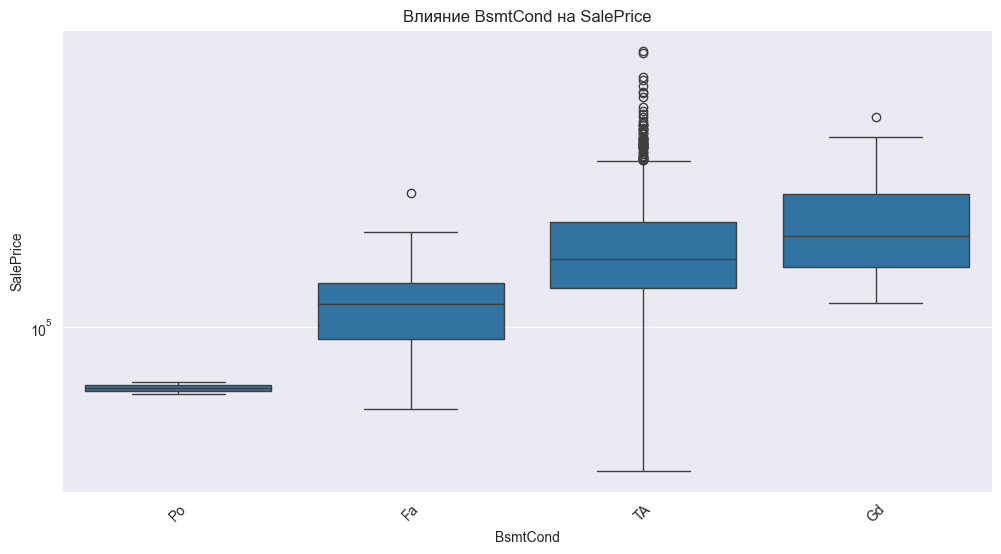

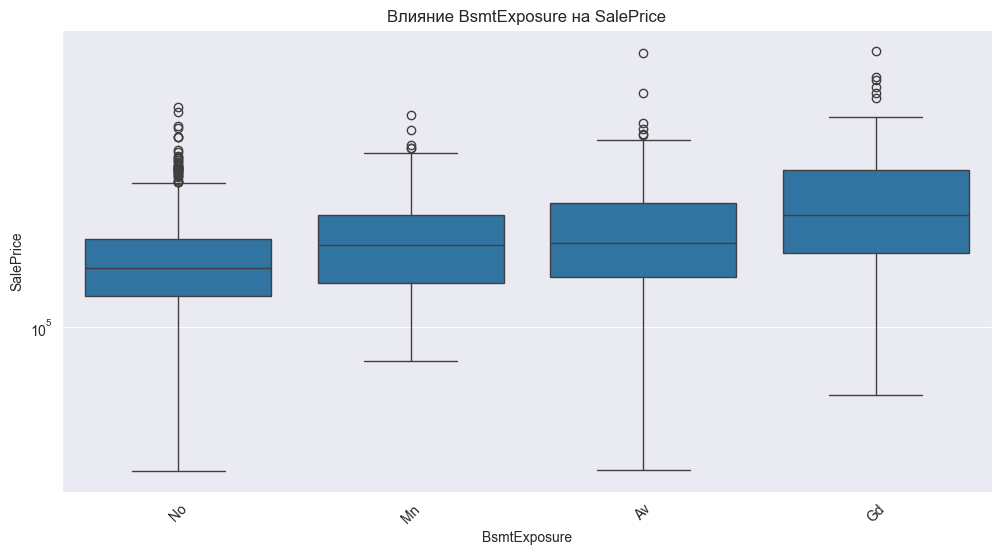

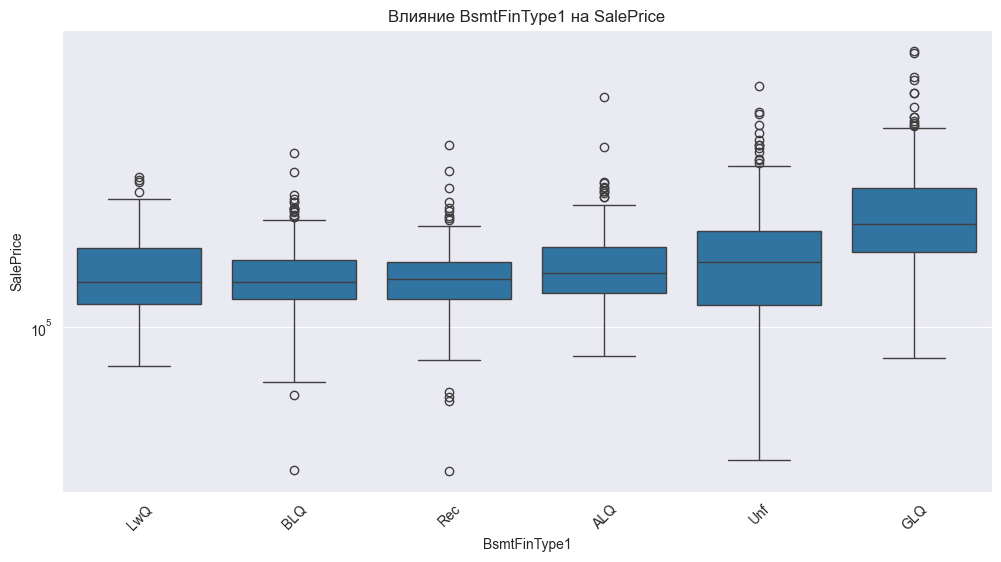

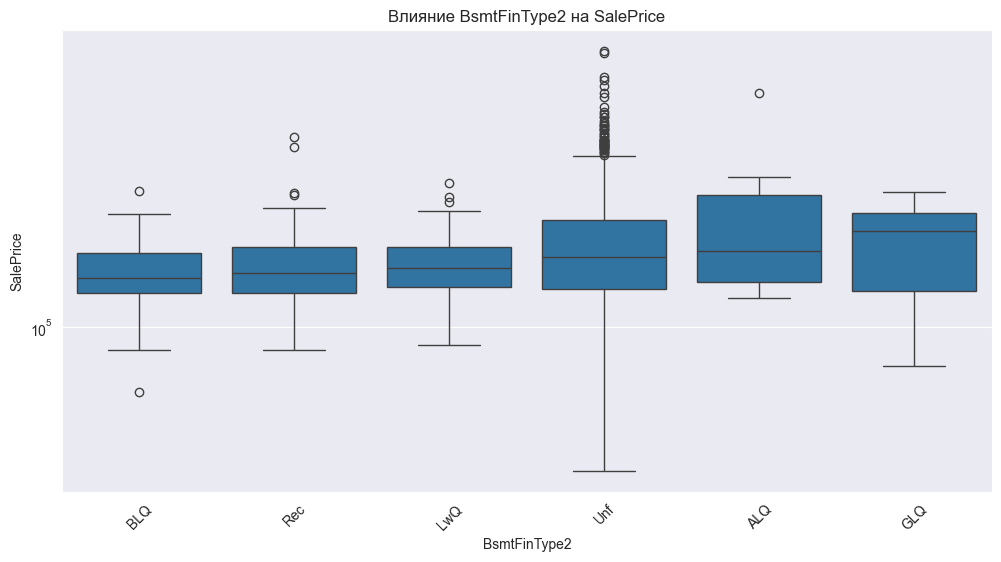

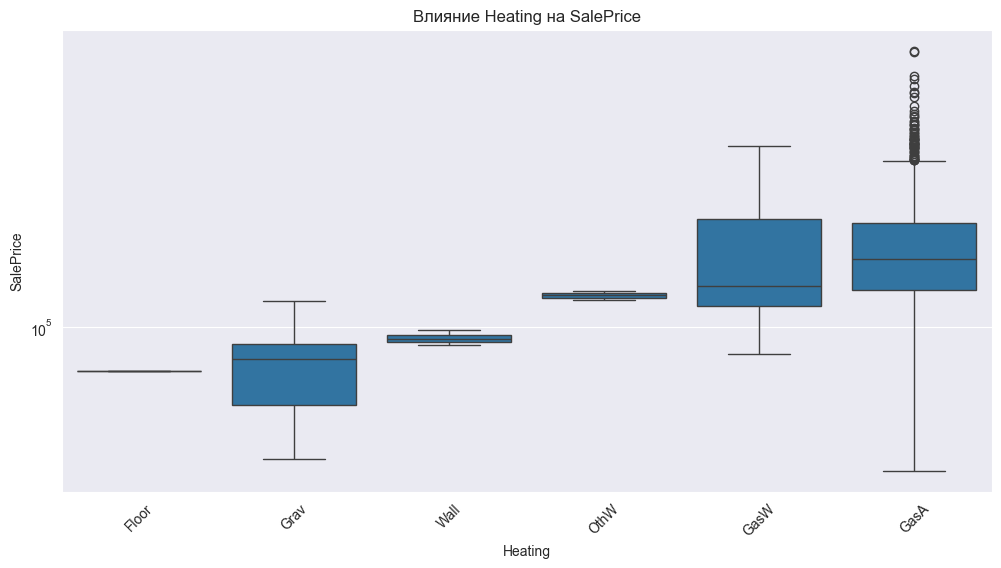

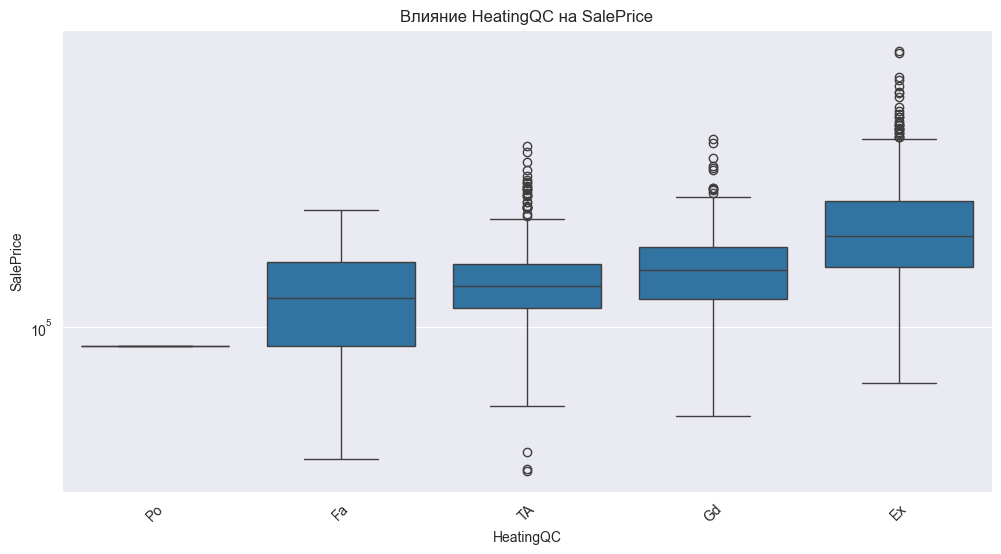

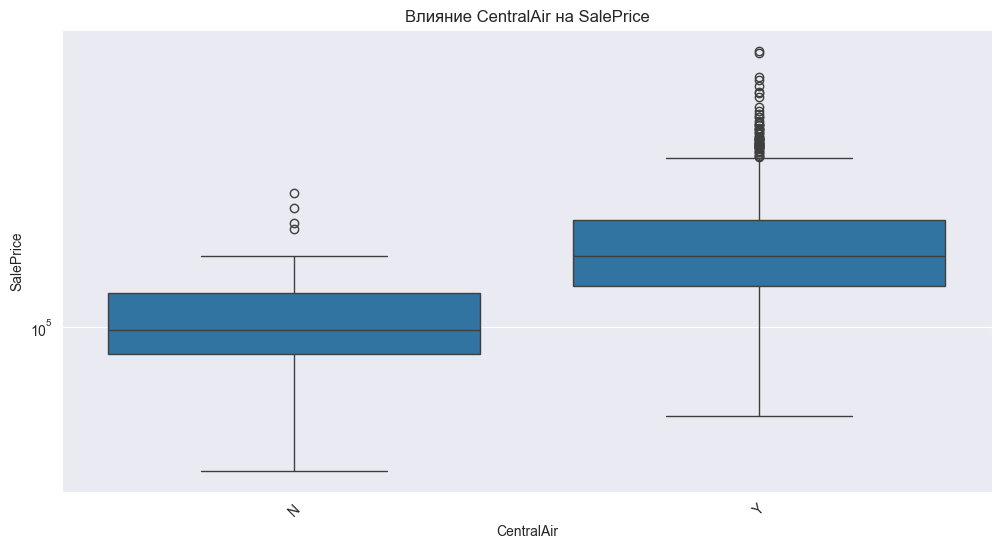

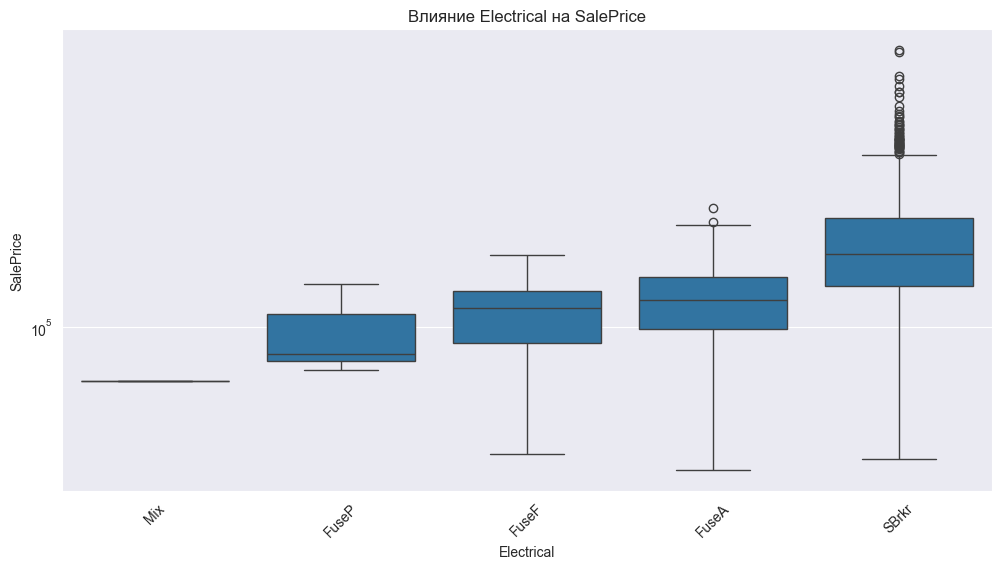

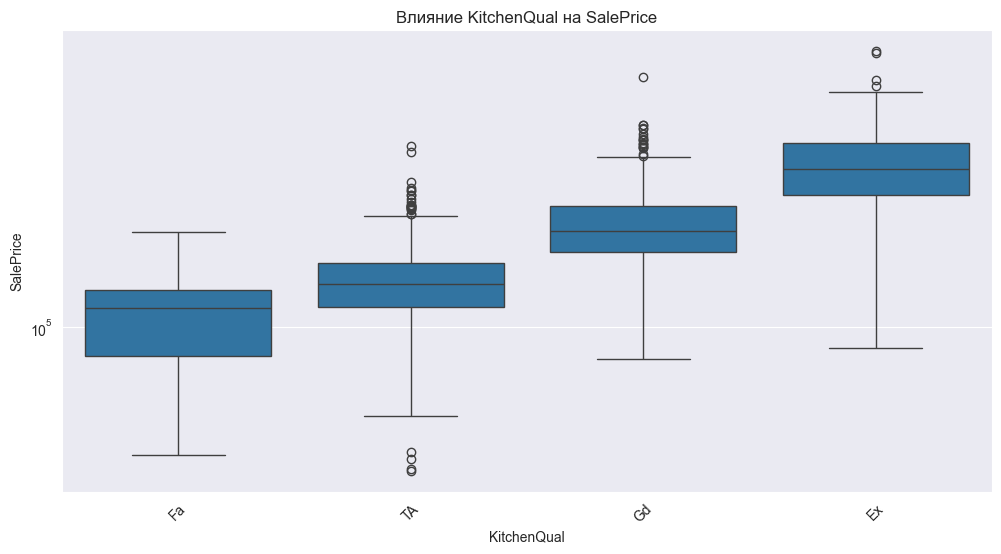

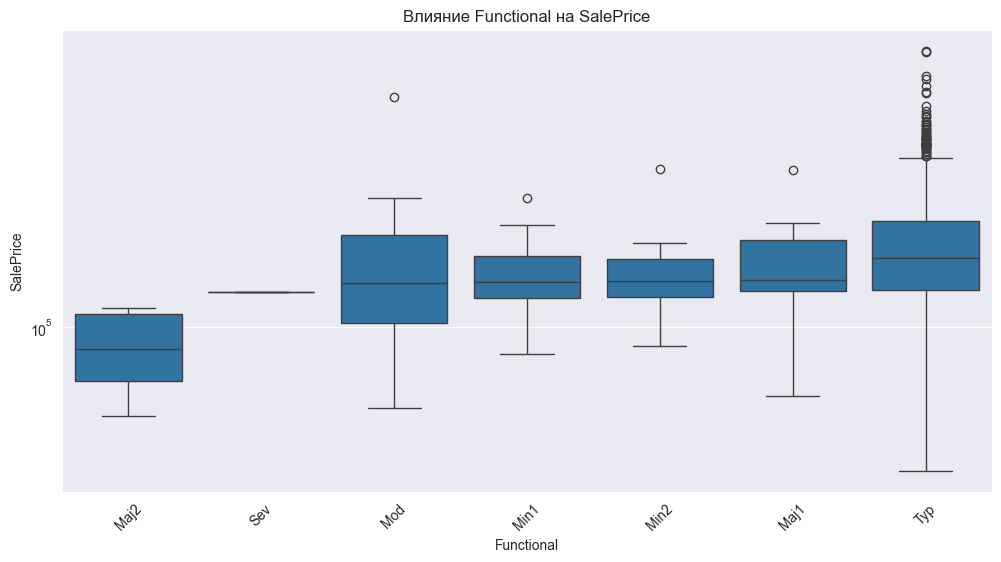

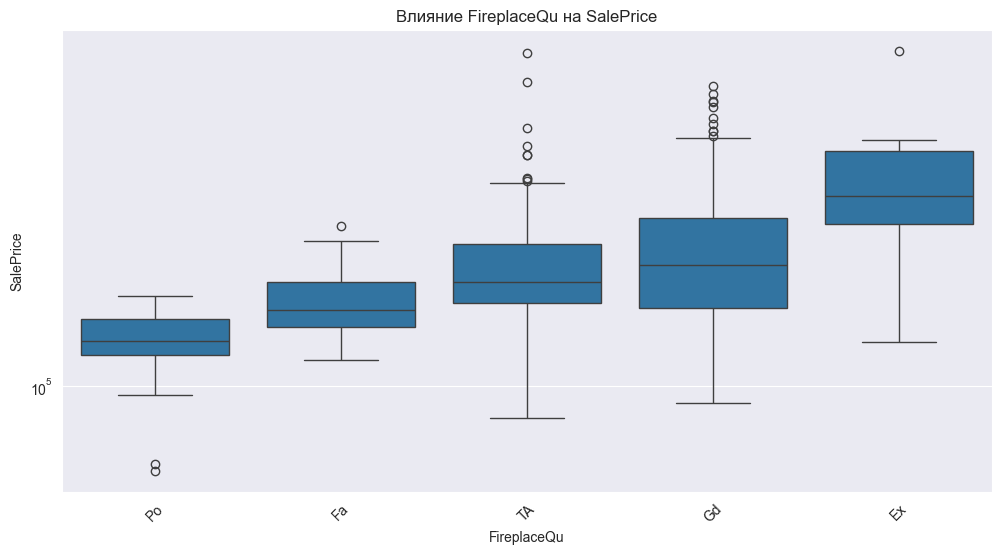

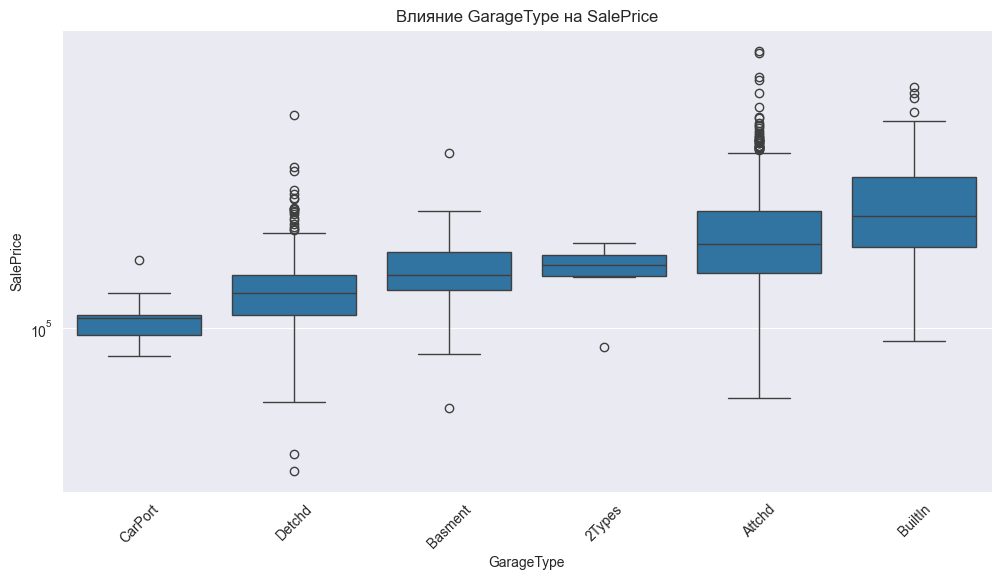

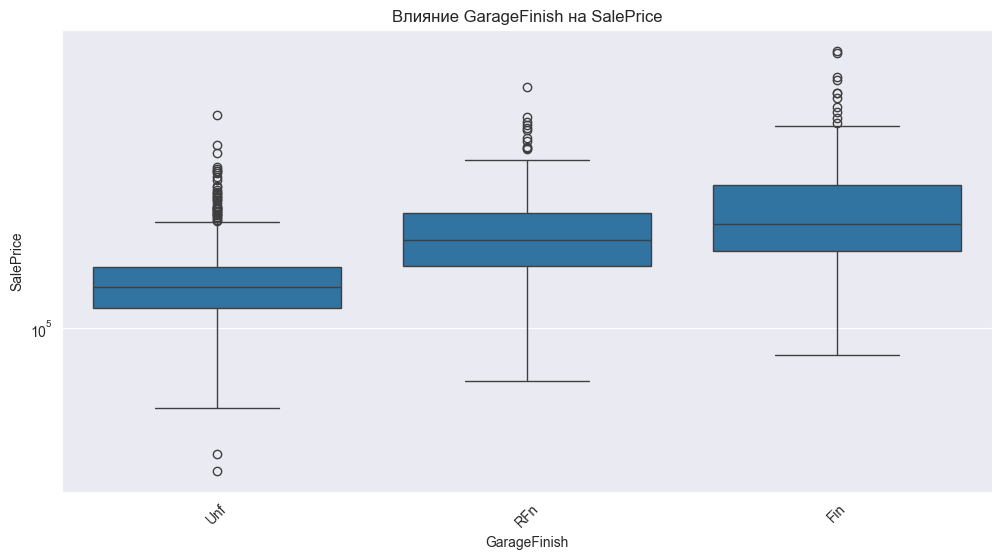

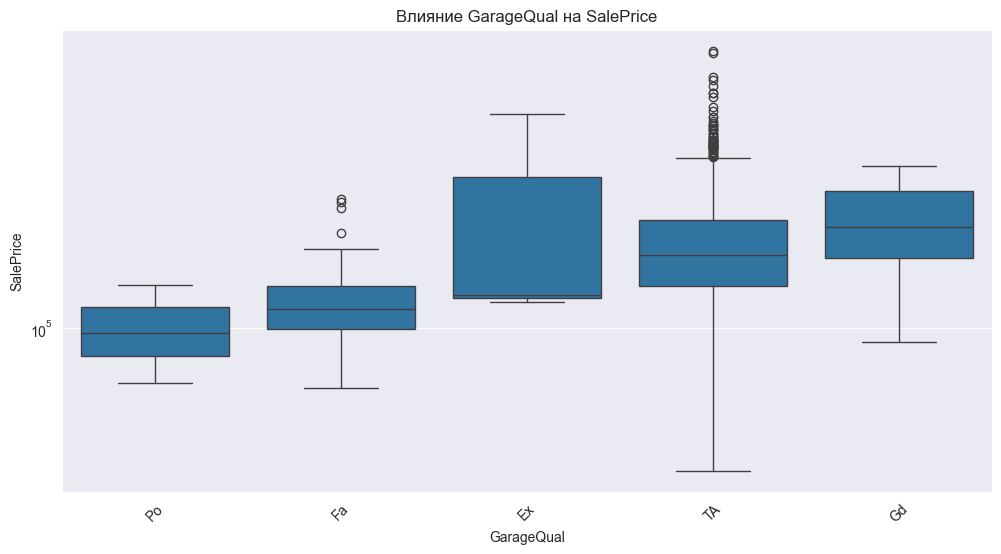

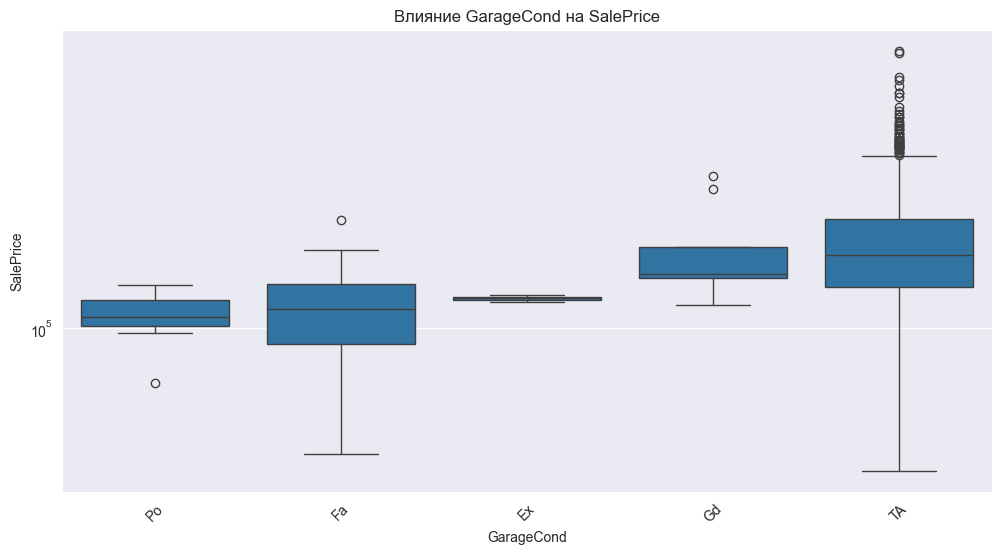

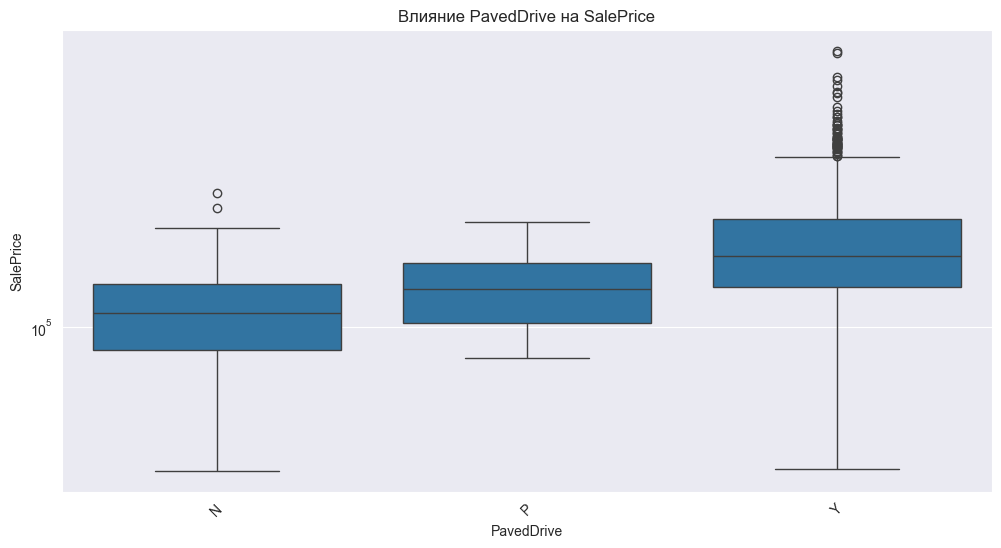

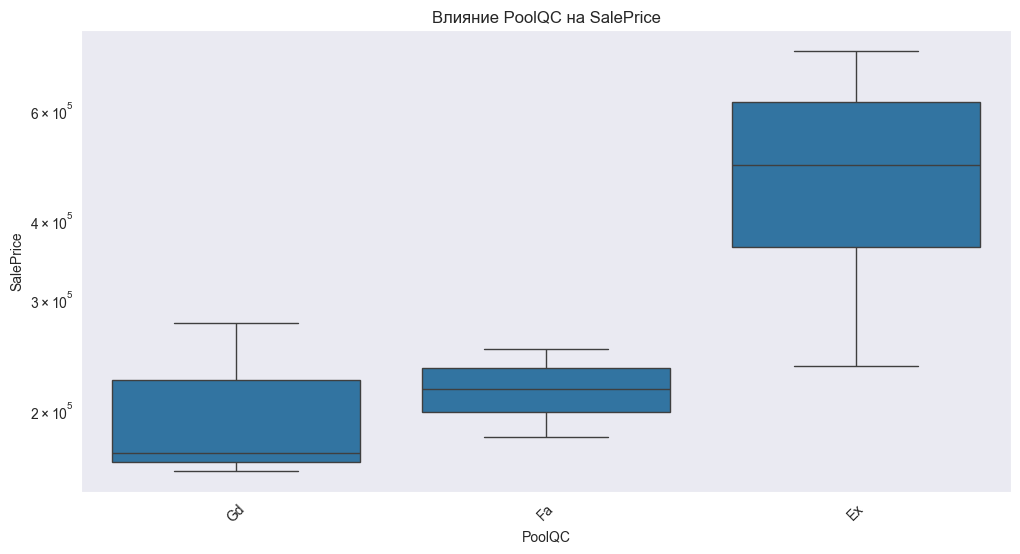

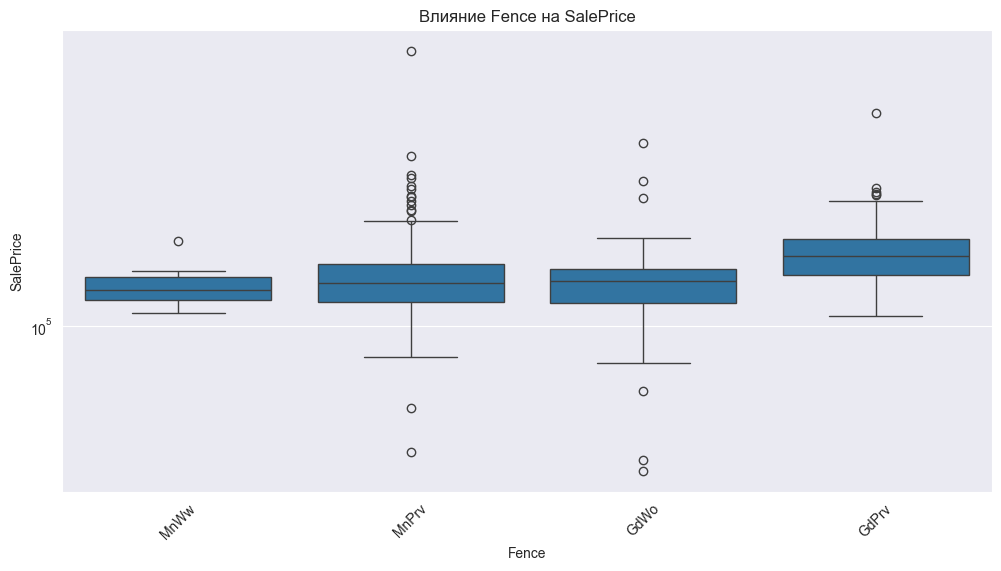

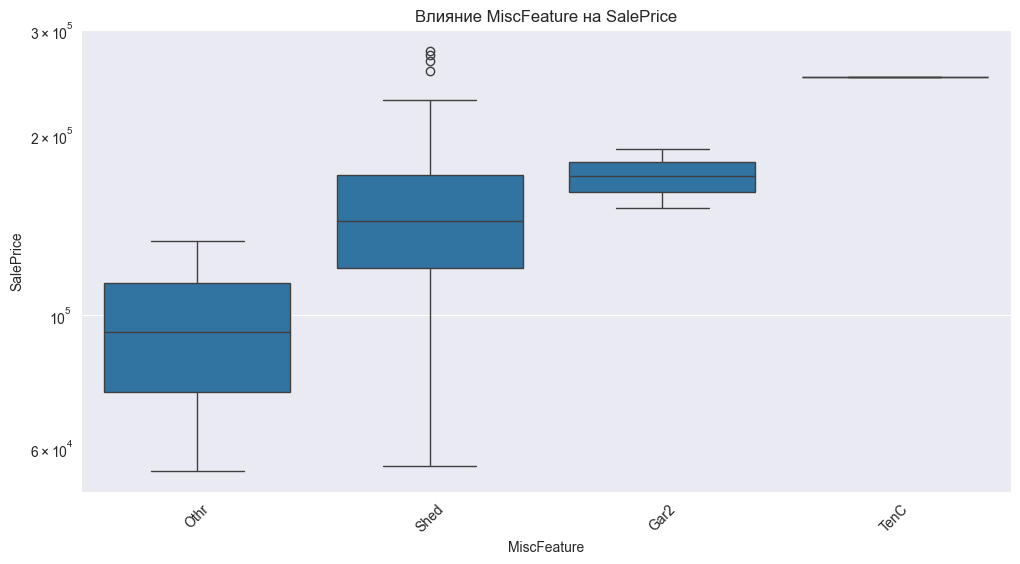

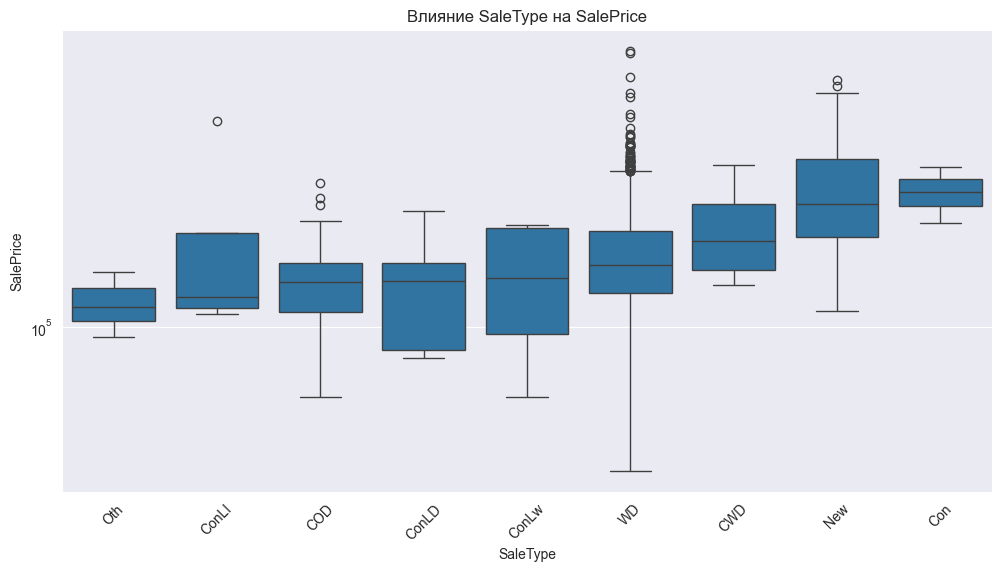

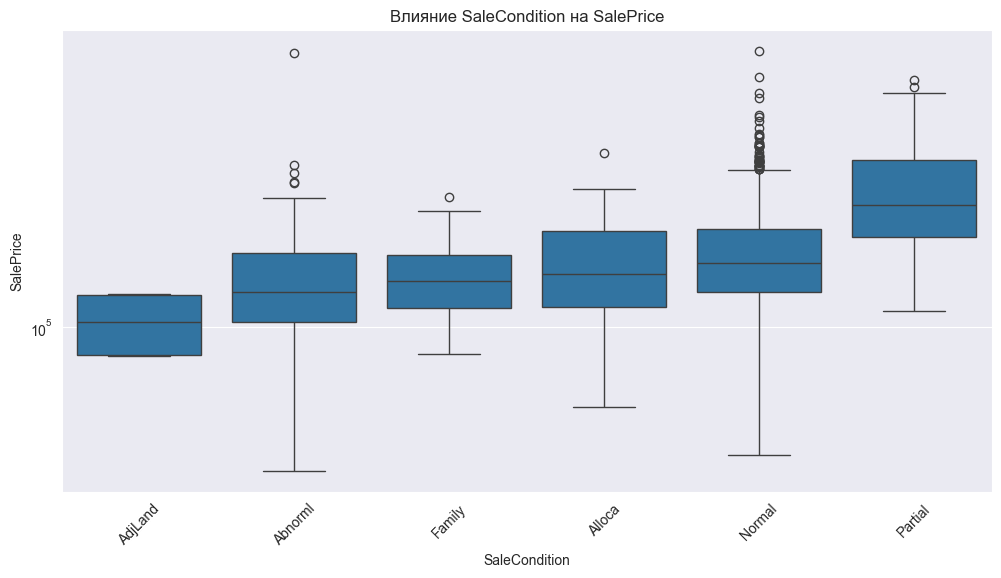

In [13]:
for col in list_cf:
    plt.figure(figsize=(12, 6))

    order = data_train.groupby(col)['SalePrice'].median().sort_values().index

    sns.boxplot(x=col, y='SalePrice', data=data_train, order=order)

    plt.title(f'Влияние {col} на SalePrice')
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.show()

In [112]:
#feature engineering
#train
data_train['TotalArea'] = data_train['TotalBsmtSF'] + data_train['1stFlrSF'] + data_train['2ndFlrSF']
data_train['YrsOld'] = data_train['YrSold'] - data_train['YearBuilt']
data_train['Total_Qual'] = data_train['OverallQual'] + data_train['OverallCond']
data_train['YearsScRem'] = data_train['YrSold'] - data_train['YearRemodAdd']
data_train['GarageScore'] = data_train['GarageArea'] * data_train['GarageCars']

#test
data_test['TotalArea'] = data_test['TotalBsmtSF'] + data_test['1stFlrSF'] + data_test['2ndFlrSF']
data_test['YrsOld'] = data_test['YrSold'] - data_test['YearBuilt']
data_test['Total_Qual'] = data_test['OverallQual'] + data_test['OverallCond']
data_test['YearsScRem'] = data_test['YrSold'] - data_test['YearRemodAdd']
data_test['GarageScore'] = data_test['GarageArea'] * data_test['GarageCars']

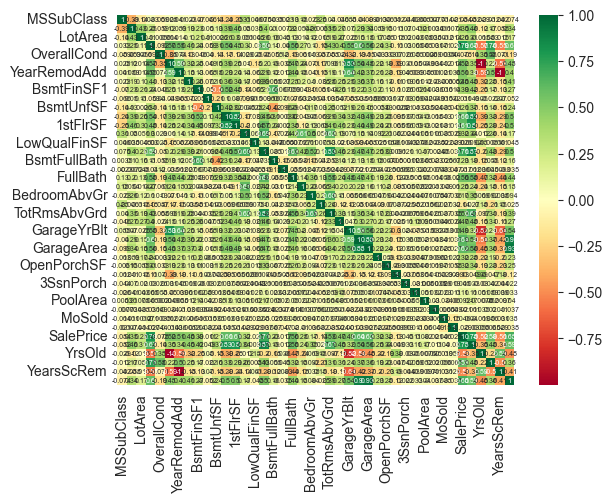

In [113]:
correlation_matrix = data_train.select_dtypes(include= ['int64', 'float64']).corr()
annot_kws = {"size": 5}
sns.heatmap(correlation_matrix, cmap = 'RdYlGn', annot = True, annot_kws=annot_kws)
plt.show()

In [114]:
#search most features
corr = data_train.select_dtypes(include= ['int64', 'float64']).corr()

In [115]:
#find most correlation
most_corr = corr['SalePrice'].sort_values(ascending=False)
positive_corr = (most_corr[most_corr  > 0.1]).drop('SalePrice')

print(positive_corr)

OverallQual     0.790982
TotalArea       0.782260
GrLivArea       0.708624
GarageScore     0.680058
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
Total_Qual      0.594786
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
Name: SalePrice, dtype: float64


In [116]:
#forming the final list of features
final_list_nf = positive_corr.index.tolist()
final_list_nf = [col for col in final_list_nf if col != 'GarageCars']
final_list_cf = ['Neighborhood', 'ExterQual', 'KitchenQual', 'BsmtQual', 'Foundation', 'SaleCondition']
all_features = final_list_nf + final_list_cf

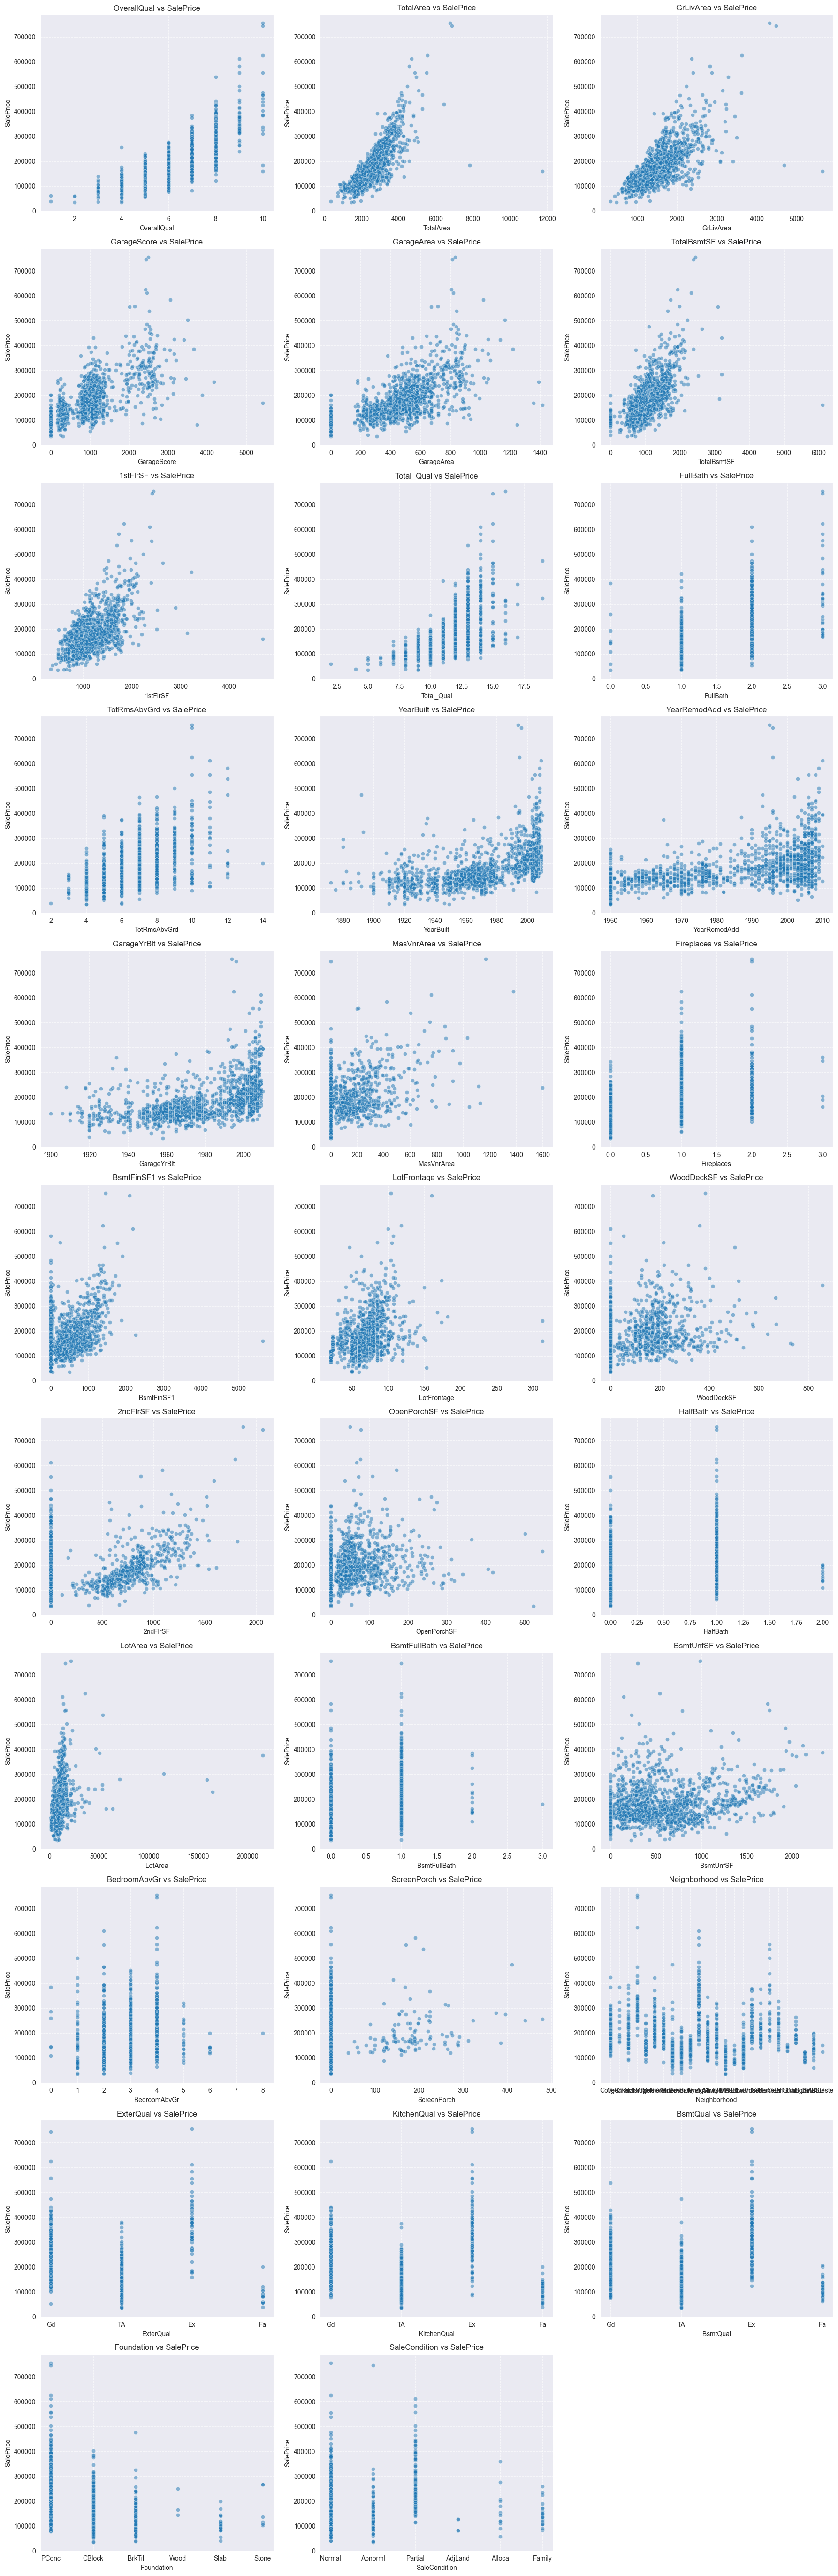

In [117]:
#building a scatterplot for a final check of all features for outliers.
cols = 3
rows = math.ceil(len(all_features) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

for i, col in enumerate(all_features):
    sns.scatterplot(data=data_train, x=col, y='SalePrice', ax=axes[i], alpha=0.5)
    axes[i].set_title(f'{col} vs SalePrice', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('SalePrice')
    axes[i].grid(True, linestyle='--', alpha=0.6)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [141]:
for col in final_list_cf:
    counts = data_train[col].value_counts()
    rare_categories = counts[counts < 10].index
    data_train[col] = data_train[col].replace(rare_categories, 'Other')
    data_test[col] = data_test[col].replace(rare_categories, 'Other')

In [142]:
#We see that in GrLivArea there are abnormal values above 4000 thousand and prices below 300 thousand. Drop them.
out = data_train[(data_train['GrLivArea'] > 4000) & (data_train['SalePrice'] < 300000)].index
data_clean = data_train.drop(out)

In [143]:
#split for train X_train and log1p for target y_train. Drop GarageArea for train and test
X_train = data_clean[all_features]
y_train = np.log1p(data_clean['SalePrice'])

data_test.drop(['GarageArea'], axis=1)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             20       RH         80.0    11622   Pave   NaN      Reg   
1             20       RL         81.0    14267   Pave   NaN      IR1   
2             60       RL         74.0    13830   Pave   NaN      IR1   
3             60       RL         78.0     9978   Pave   NaN      IR1   
4            120       RL         43.0     5005   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1454         160       RM         21.0     1936   Pave   NaN      Reg   
1455         160       RM         21.0     1894   Pave   NaN      Reg   
1456          20       RL        160.0    20000   Pave   NaN      Reg   
1457          85       RL         62.0    10441   Pave   NaN      Reg   
1458          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... MiscVal MoSold YrSold SaleType  \
0            Lvl    AllPub    Inside  ...       0      6   2010       WD   
1            Lvl    AllPub    Corner  ...   12500      6   2010       WD   
2            Lvl    AllPub    Inside  ...       0      3   2010       WD   
3            Lvl    AllPub    Inside  ...       0      6   2010       WD   
4            HLS    AllPub    Inside  ...       0      1   2010       WD   
...          ...       ...       ...  ...     ...    ...    ...      ...   
1454         Lvl    AllPub    Inside  ...       0      6   2006       WD   
1455         Lvl    AllPub    Inside  ...       0      4   2006       WD   
1456         Lvl    AllPub    Inside  ...       0      9   2006       WD   
1457         Lvl    AllPub    Inside  ...     700      7   2006       WD   
1458         Lvl    AllPub    Inside  ...       0     11   2006       WD   

     SaleCondition TotalArea  YrsOld  Total_Qual  YearsScRem  GarageScore  
0           Normal    1778.0      49          11          49        730.0  
1           Normal    2658.0      52          12          52        312.0  
2           Normal    2557.0      13          10          12        964.0  
3           Normal    2530.0      12          12          12        940.0  
4           Normal    2560.0      18          13          18       1012.0  
...            ...       ...     ...         ...         ...          ...  
1454        Normal    1638.0      36          11          36          0.0  
1455       Abnorml    1638.0      36           9          36        286.0  
1456       Abnorml    2448.0      46          12          10       1152.0  
1457        Normal    1882.0      14          10          14          0.0  
1458        Normal    2996.0      13          12          12       1950.0  

[1459 rows x 83 columns]

In [144]:
#initiation algorithms for regression
x_gb = XGBRegressor(random_state=42)
l_gb = LGBMRegressor(random_state=42)
l1 = Lasso(random_state=42)
l2 = Ridge(random_state=42)

In [145]:
#init preprocessing methods
imputer_numeric = SimpleImputer(strategy='median')
imputer_categorical = SimpleImputer(strategy='constant', fill_value='None')
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
scaler = StandardScaler()


In [146]:
#steps for transform for numeric and categorial features
numeric_transformer = Pipeline(steps=[
    ('imputer_numeric', imputer_numeric),
    ('scaler', scaler)
])

categorical_transformer = Pipeline(steps=[
    ('imputer_categorial', imputer_categorical),
    ('encoder', oe)
])

In [147]:
#make preprocessor for numeric and categorial features
preprocessor = ColumnTransformer(transformers=[('numeric', numeric_transformer, final_list_nf), ('categorical', categorical_transformer, final_list_cf)])

In [148]:
#make pipeline for xgb and lgb for the search best params
pipe_x_gb = Pipeline([('preprocessor', preprocessor), ('x_gb', x_gb)])
pipe_l_gb = Pipeline([('preprocessor', preprocessor), ('l_gb', l_gb)])
pipe_l2 = Pipeline([('preprocessor', preprocessor), ('l2', l2)])

#search the best params for XGboost and LightGBM
params_x_gb = {'x_gb__n_estimators': range(10, 300, 10), 'x_gb__max_depth': range(1, 5), 'x_gb__learning_rate': [0.005, 0.05, 0.25, 0.5, 1]}
params_l_gb = {'l_gb__n_estimators': range(10, 300, 10), 'l_gb__max_depth': range(1, 5), 'l_gb__learning_rate': [0.005, 0.05, 0.25, 0.5, 1]}
params_l2 = {'l2__alpha': [0, 0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100]}

In [149]:
#search the best params
grid_x_gb = GridSearchCV(estimator=pipe_x_gb, param_grid=params_x_gb, cv=10, n_jobs=-1)
grid_l_gb = GridSearchCV(estimator=pipe_l_gb, param_grid=params_l_gb, cv=10, n_jobs=-1)
grid_l2 = GridSearchCV(estimator=pipe_l2, param_grid=params_l2, cv=10, n_jobs=-1)

In [150]:
#fit grid x_gb
grid_x_gb.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer_numeric',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'TotalArea',
                                                                          'GrLivArea',
                                                                          'GarageScore',
                                                                          'GarageArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'Total_Qual',
                                                                          'FullBath',
                                                                          'TotRmsAbvGrd',
                                                                          'YearBuilt',
                                                                          'Year...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'x_gb__learning_rate': [0.005, 0.05, 0.25, 0.5, 1],
                         'x_gb__max_depth': range(1, 5),
                         'x_gb__n_estimators': range(10, 300, 10)})

In [151]:
best_params_x_gb = grid_x_gb.best_params_
print(f'Best params for x_gb: {best_params_x_gb}')

Best params for x_gb: {'x_gb__learning_rate': 0.05, 'x_gb__max_depth': 4, 'x_gb__n_estimators': 280}


In [152]:
#fit grid l_gb
grid_l_gb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 1458, number of used features: 32
[LightGBM] [Info] Start training from score 12.024015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer_numeric',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'TotalArea',
                                                                          'GrLivArea',
                                                                          'GarageScore',
                                                                          'GarageArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'Total_Qual',
                                                                          'FullBath',
                                                                          'TotRmsAbvGrd',
                                                                          'YearBuilt',
                                                                          'Year...
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Neighborhood',
                                                                          'ExterQual',
                                                                          'KitchenQual',
                                                                          'BsmtQual',
                                                                          'Foundation',
                                                                          'SaleCondition'])])),
                                       ('l_gb',
                                        LGBMRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'l_gb__learning_rate': [0.005, 0.05, 0.25, 0.5, 1],
                         'l_gb__max_depth': range(1, 5),
                         'l_gb__n_estimators': range(10, 300, 10)})

In [159]:
best_params_l_gb = grid_l_gb.best_params_
print(f'Best params for l_gb: {best_params_l_gb}')

Best params for l_gb: {'l_gb__learning_rate': 1, 'l_gb__max_depth': 1, 'l_gb__n_estimators': 280}


In [160]:
grid_l2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer_numeric',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['OverallQual',
                                                                          'TotalArea',
                                                                          'GrLivArea',
                                                                          'GarageScore',
                                                                          'GarageArea',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'Total_Qual',
                                                                          'FullBath',
                                                                          'TotRmsAbvGrd',
                                                                          'YearBuilt',
                                                                          'Year...
                                                                         Pipeline(steps=[('imputer_categorial',
                                                                                          SimpleImputer(fill_value='None',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['Neighborhood',
                                                                          'ExterQual',
                                                                          'KitchenQual',
                                                                          'BsmtQual',
                                                                          'Foundation',
                                                                          'SaleCondition'])])),
                                       ('l2', Ridge(random_state=42))]),
             n_jobs=-1,
             param_grid={'l2__alpha': [0, 0.001, 0.01, 0.1, 1, 10, 25, 50, 75,
                                       100]})

In [161]:
best_params_l2 = grid_l2.best_params_
print(f'Best params for x_gb: {best_params_l2}')

Best params for x_gb: {'l2__alpha': 25}


In [162]:
#init best_estimator for model
best_estimator_x_gb = grid_x_gb.best_estimator_
best_estimator_l_gb = grid_l_gb.best_estimator_
best_estimator_l2 = grid_l2.best_estimator_

In [163]:
#predict for data_test
p1 = best_estimator_x_gb.predict(data_test)
p2 = best_estimator_l_gb.predict(data_test)
p3 = best_estimator_l2.predict(data_test)

C:\Users\solovyev_na\Desktop\Jupyter\House_price\.myenv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [164]:
#blending and weights
final_sum_p = (p1 * 0.45) + (p2 * 0.45) + (p3 * 0.1)
final_price = np.expm1(final_sum_p)

In [165]:
#save the submit
data_sub = pd.read_csv('test.csv')
submission = pd.DataFrame({'Id': data_sub['Id'], 'SalePrice': final_price})
submission.to_csv('submission.csv', index=False)